## In this Notebook I will start with the very Basics of RNN's and Build all the way to latest deep learning architectures to solve NLP problems. It will cover the Following:

### Simple RNN's
### Word Embeddings : Definition and How to get them
### LSTM's
### GRU's
### BI-Directional RNN's
### Encoder-Decoder Models (Seq2Seq Models)
### Attention Models
### Transformers - Attention is all you need
### BERT

In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt


In [23]:
# Import our dataset 
train = pd.read_csv('/kaggle/input/religion-hates/augmented_tweets2.csv', encoding='utf-16')
test = pd.read_csv('/kaggle/input/religion-hates/test_tweets.csv', encoding='utf-16')
train.head()

,Unnamed: 0,Unnamed: 0.1,tweet,hate,id
0,0,0.0,بمجرد ما يريدون ان يفرضوا عليك الاسلام تتحول ح...,1.0,NaN
1,1,1.0,مشي معقول مفتي السعوديه اكبر دوله سنيه يفتي بم...,1.0,NaN
2,2,2.0,انا اولكم وباذن الله كل التوفيق والفوز الساحق ...,1.0,NaN
3,3,3.0,تيار المحبه اليمن رءيس الهيءه العليا في تيار ا...,0.0,NaN
4,4,4.0,قالها الاكسبشني عنخيركم ما تنامون عنخيركم يهود...,1.0,NaN


In [24]:
# We will do binary classification and we will take sample dataset:
train.drop(['Unnamed: 0','Unnamed: 0.1','id',], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

In [25]:
train.shape

(12652, 2)

In [26]:
train.head()

,tweet,hate
0,بمجرد ما يريدون ان يفرضوا عليك الاسلام تتحول ح...,1.0
1,مشي معقول مفتي السعوديه اكبر دوله سنيه يفتي بم...,1.0
2,انا اولكم وباذن الله كل التوفيق والفوز الساحق ...,1.0
3,تيار المحبه اليمن رءيس الهيءه العليا في تيار ا...,0.0
4,قالها الاكسبشني عنخيركم ما تنامون عنخيركم يهود...,1.0


In [27]:
train.drop_duplicates(subset="tweet",
                     keep=False, inplace=True)

In [28]:
# Getting max number of words coz this will help us in padding later 
train['tweet'].apply(lambda x: len(str(x).split())).max()

65

In [47]:
# Writing a function to getting AUC score for validation: 
# Understand ROC vs AUC score 
def auc(pred, target):
    fpr, tpr, threshold = metrics.roc_curve(target, pred)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    return (metrics.auc(fpr, tpr)),

In [30]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.tweet.values, train.hate.values, test_size = 0.2, random_state = 42, stratify= train.hate.values, shuffle = True)

## Simple RNN:
Recurrent Neural Network(RNN) are a type of Neural Network where the output from previous step are fed as input to the current step. In traditional neural networks, all the inputs and outputs are independent of each other, but in cases like when it is required to predict the next word of a sentence, the previous words are required and hence there is a need to remember the previous words. Thus RNN came into existence, which solved this issue with the help of a Hidden Layer.

Why RNN's?

https://www.quora.com/Why-do-we-use-an-RNN-instead-of-a-simple-neural-network

In [31]:
# Using Keras Tokenizer:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
token = Tokenizer()
max_len = 65
token.fit_on_texts(list(xtrain) + list(xvalid))

In [32]:
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len)

In [33]:
word_index = token.word_index

In [34]:
# RNN model 
model = Sequential()
model.add(Embedding(len(word_index)+1, 300, input_length=65))
model.add(SimpleRNN(100))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 65, 300)           5832000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               40100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 5,872,201
Trainable params: 5,872,201
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit(xtrain_pad, ytrain, epochs = 5)

Epoch 1/5
142/142 [==============================] - 12s 73ms/step - loss: 0.6147 - accuracy: 0.6361
Epoch 2/5
142/142 [==============================] - 10s 71ms/step - loss: 0.0844 - accuracy: 0.9778
Epoch 3/5
142/142 [==============================] - 10s 73ms/step - loss: 0.0396 - accuracy: 0.9872
Epoch 4/5
142/142 [==============================] - 11s 76ms/step - loss: 0.0288 - accuracy: 0.9895
Epoch 5/5
142/142 [==============================] - 11s 76ms/step - loss: 0.0173 - accuracy: 0.9958


In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.ylabel('Actuals')
plt.xlabel('Predictions')
plt.show()

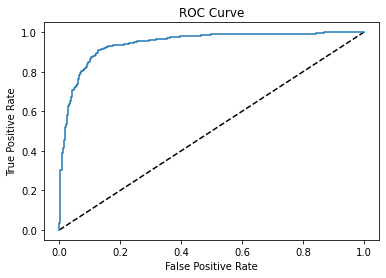

(0.9443510033638789,)

In [48]:
scores = model.predict(xvalid_pad)
auc(scores, yvalid)

In [45]:
def aucx(pred, target):    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(pred , target)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [ ]:
model.save('model1_rnn.h')


### Code Explanation:
Tokenization

So if you have watched the videos and referred to the links, you would know that in an RNN we input a sentence word by word. We represent every word as one hot vectors of dimensions : Numbers of words in Vocab +1.
What keras Tokenizer does is , it takes all the unique words in the corpus,forms a dictionary with words as keys and their number of occurences as values,it then sorts the dictionary in descending order of counts. It then assigns the first value 1 , second value 2 and so on. So let's suppose word 'the' occured the most in the corpus then it will assigned index 1 and vector representing 'the' would be a one-hot vector with value 1 at position 1 and rest zereos.
Try printing first 2 elements of xtrain_seq you will see every word is represented as a digit now.

In [17]:
xtrain_seq[:1]

[[2038, 19, 106, 5, 123, 70, 1, 888, 588, 14]]

We have done PADDING to make sequance equal inputs:
#### Building the Neural Network
To understand the Dimensions of input and output given to RNN in keras her is a beautiful article : https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e

The first line model.Sequential() tells keras that we will be building our network sequentially . Then we first add the Embedding layer. Embedding layer is also a layer of neurons which takes in as input the nth dimensional one hot vector of every word and converts it into 300 dimensional vector , it gives us word embeddings similar to word2vec. We could have used word2vec but the embeddings layer learns during training to enhance the embeddings. Next we add an 100 RNN units without any dropout or regularization At last we add a single neuron with sigmoid function which takes output from 100 RNN cells (Please note we have 100 LSTM cells not layers) to predict the results and then we compile the model using adam optimizer..

### Comments on the model

We can see our model achieves an accuracy of 1 which is just insane , we are clearly overfitting I know , but this was the simplest model of all ,we can tune a lot of hyperparameters like RNN units, we can do batch normalization , dropouts etc to get better result. The point is we got an AUC score of 0.82 without much efforts and we know have learnt about RNN's .Deep learning is really revolutionary

## Word Embeddings: 

While building our simple RNN models we talked about using word-embeddings , So what is word-embeddings and how do we get word-embeddings? Here is the answer :

https://www.coursera.org/learn/nlp-sequence-models/lecture/6Oq70/word-representation
https://machinelearningmastery.com/what-are-word-embeddings/

The latest approach to getting word Embeddings is using pretained GLoVe or using Fasttext. Without going into too much details, I would explain how to create sentence vectors and how can we use them to create a machine learning model on top of it and since I am a fan of GloVe vectors, word2vec and fasttext. In this Notebook, I'll be using the GloVe vectors. You can download the GloVe vectors from here http://www-nlp.stanford.edu/data/glove.840B.300d.zip or you can search for GloVe in datasets on Kaggle and add the file

In [18]:
!rm -rf /kaggle/working/glove.6B.zip.1
!rm -rf /kaggle/working/glove.6B.zip

In [19]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-01-09 12:52:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-09 12:52:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-09 12:52:29--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [20]:
!unzip /kaggle/working/glove.6B.zip

Archive:  /kaggle/working/glove.6B.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /kaggle/working/glove.6B.zip or
        /kaggle/working/glove.6B.zip.zip, and cannot find /kaggle/working/glove.6B.zip.ZIP, period.


In [21]:
# Load Glove model in Dictionary: 
glove = {}
f = open('/kaggle/working/glove.6B.300d.txt', 'r')
for line in f:
    line = line.split(' ')
    word = line[0]
    coeff = np.asarray([float(val) for val in line[1:]])
    glove[word] = coeff
f.close()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/glove.6B.300d.txt'

In [ ]:
# Create Embedding metrics for words we have in dataset: 
embedding_metrics = np.zeros((len(word_index)+1, 300))
for word, i in word_index.items():
    embedding = glove.get(word)
    if embedding is not None:
        embedding_metrics[i] = embedding

## LSTM's:

Simple RNN's were certainly better than classical ML algorithms and gave state of the art results, but it failed to capture long term dependencies that is present in sentences . So in 1998-99 LSTM's were introduced to counter to these drawbacks.

#### Code Implementation
We have already tokenized and paded our text for input to LSTM's



In [ ]:
# LSTM model 
model = Sequential()
model.add(Embedding(len(word_index)+1, 300, weights=[embedding_metrics], input_length=65, trainable=False))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(xtrain_pad, ytrain, epochs = 5)

In [ ]:
scores = model.predict(xvalid_pad)
auc(scores, yvalid)

In [ ]:
model.save('model2_lstm')


### Code Explanation
As a first step we calculate embedding matrix for our vocabulary from the pretrained GLoVe vectors . Then while building the embedding layer we pass Embedding Matrix as weights to the layer instead of training it over Vocabulary and thus we pass trainable = False. Rest of the model is same as before except we have replaced the SimpleRNN By LSTM Units

Comments on the Model
We now see that the model is not overfitting and achieves an auc score of 0.96 which is quite commendable , also we close in on the gap between accuracy and auc . We see that in this case we used dropout and prevented overfitting the data

## GRU's
### Basic Overview
Introduced by Cho, et al. in 2014, GRU (Gated Recurrent Unit) aims to solve the vanishing gradient problem which comes with a standard recurrent neural network. GRU's are a variation on the LSTM because both are designed similarly and, in some cases, produce equally excellent results . GRU's were designed to be simpler and faster than LSTM's and in most cases produce equally good results and thus there is no clear winner.

In [ ]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_metrics],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

In [ ]:
model.fit(xtrain_pad, ytrain, epochs = 5)

In [ ]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (auc(scores,yvalid)))

In [ ]:
model.save('model3_gru')


## Bi-Directional RNN's:
Code is same as before,only we have added bidirectional nature to the LSTM cells we used before and is self explanatory. We have achieve similar accuracy and auc score as before and now we have learned all the types of typical RNN architectures

In [ ]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_metrics],
                     input_length=max_len,
                     trainable=False))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    
model.summary()

In [ ]:
# IT takes more time so i did not implement this